In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

/home/toto9/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


o dataset de imagens ta salvo dentro do .fastai/data

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [ ]:
(path/"images").ls()

(#7393) [Path('images/newfoundland_193.jpg'),Path('images/german_shorthaired_116.jpg'),Path('images/yorkshire_terrier_51.jpg'),Path('images/yorkshire_terrier_38.jpg'),Path('images/saint_bernard_107.jpg'),Path('images/english_cocker_spaniel_171.jpg'),Path('images/Birman_15.jpg'),Path('images/Siamese_144.jpg'),Path('images/english_setter_193.jpg'),Path('images/japanese_chin_18.jpg')...]

Inicializando o DataBlock de imagens e categorias, passando regex para pegar os labels dos animais

In [ ]:
pets = DataBlock(blocks= (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                    item_tfms=Resize(460),
                    batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

```
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)
```

These lines implement a fastai data augmentation strategy which we call presizing. Presizing is a particular way to do image augmentation that is designed to minimize data destruction while maintaining good performance.


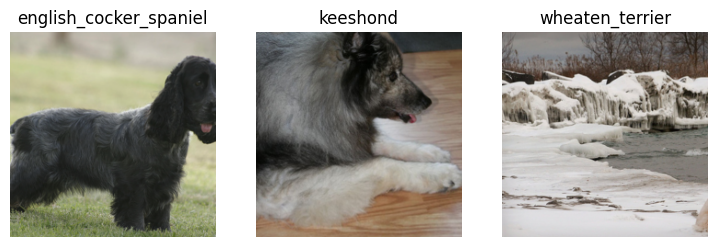

In [ ]:
dls.show_batch(nrows=1, ncols=3)

Step of training a simple model before training an actual model

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.522665,0.351048,0.108931,08:24


epoch,train_loss,valid_loss,error_rate,time
0,0.488189,0.353606,0.117050,10:16
1,0.316640,0.242647,0.084574,10:41


O fastai vai tentar escolher uma loss function adequada para o problema, mas você pode escolher uma loss function específica se quiser.
Nesse caso, ta usando a cross-entropy loss function

Para entender como a cross-entropy loss funciona, temos que entender como o dado real e as ativacoes das camadas vistas pela função de loss são

In [ ]:
## pegando um batch do dado real do DataLoaders
## x eh a variavel dependente e y a independente
x, y = dls.one_batch()

In [ ]:
y

TensorCategory([14, 28,  7, 33,  6, 33,  0,  3, 34, 33, 21, 14, 16, 31, 10, 35,
                34, 36, 15, 26, 20, 28, 11,  2,  1,  8, 19, 15, 24, 34, 35, 11,
                15, 31, 10, 24, 22, 36, 16,  4, 26, 32, 34, 24, 23, 27,  8, 19,
                25, 31, 30, 26, 10, 19,  0, 30, 25, 19, 26,  1, 32, 13, 31, 36])

Our batch size is 64, so we have 64 rows in this tensor. Each row is a single integer between 0 and 36, representing our 37 possible pet breeds. We can view the predictions (that is, the activations of the final layer of our neural network) using Learner.get_preds. This function either takes a dataset index (0 for train and 1 for valid) or an iterator of batches. Thus, we can pass it a simple list with our batch to get our predictions. It returns predictions and targets by default, but since we already have the targets, we can effectively ignore them by assigning to the special variable _:

In [ ]:
## targs eh o msm vetor y, pode ser usado como _ para ignorar
preds, targs = learn.get_preds(dl=[(x, y)])
preds[0]

tensor([2.7464e-06, 5.9345e-07, 5.9180e-08, 8.0671e-09, 1.3001e-08, 2.1722e-08,
        7.5312e-08, 1.1253e-07, 1.1233e-06, 3.2943e-08, 4.9263e-08, 2.9284e-08,
        1.4152e-07, 2.9968e-08, 9.9961e-01, 3.5834e-04, 3.2435e-07, 1.6786e-09,
        2.0597e-06, 2.8728e-07, 7.5139e-08, 8.3457e-07, 9.4283e-09, 9.1135e-09,
        3.6666e-08, 4.4572e-08, 1.3729e-07, 1.5662e-07, 4.8348e-10, 4.1348e-09,
        2.3188e-05, 7.1083e-08, 8.0229e-08, 8.2745e-08, 2.9115e-09, 1.2759e-07,
        2.0019e-08])

In [ ]:
## se somar todos os valores do vetor de predicao, o resultado eh 1
## pois eh a probabilidade de cada classe
len(preds[0]), preds[0].sum()

(37, tensor(1.0000))

para transformar as ativacoes do modelo em predicoes, usa-se a softmax activation function